importing the required packages and libraries.

In [1]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json


Using TensorFlow backend


Globale Variable

In [2]:
# Path
gv_path_models= "workspace/models/"
gv_path_images = "workspace/images/original_name/"
gv_annotation_path= "workspace/annotations/original/pascal/"
gv_model_path = "workspace/models/detector.h5"
gv_bbox_path = "workspace/models/bbox"
WORKSPACE_PATH = 'workspace'
IMAGE_PATH = WORKSPACE_PATH+'/images'

SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

The Dataset Preparation

In [3]:
class_ids = [
"Ausbildung",
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]
sub_class_ids = [
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]
main_class_ids=[
    #"Ausbildung",
    "Person" ,
    "Wohnsitz",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
main_class_mapping = dict(zip(range(len(main_class_ids)), main_class_ids))
sub_class_mapping = dict(zip(range(len(sub_class_ids)), sub_class_ids))

In [4]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gv_annotation_path, file_name)
        for file_name in os.listdir(gv_annotation_path)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gv_path_images, file_name)
        for file_name in os.listdir(gv_path_images)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [5]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [6]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(gv_path_images, image_name)
    
    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        boxes.append( create_box(bbox))
        #main labels
        #(cls=='Ausbildung') or
        if  (cls =='Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append( create_box(bbox))
        else:
            bbox = obj.find("bndbox")
            sub_boxes.append( create_box(bbox))
            sub_classes.append(cls)

    class_ids = map_class_id(classes, cls)
    main_class_ids = map_class_id(main_classes, cls)            
    sub_class_ids = map_class_id(sub_classes, cls)

    return image_path, boxes, class_ids, main_class_ids, sub_class_ids, main_boxes, sub_boxes, image_name
 

In [7]:
image_paths = []
image_names = []
bbox = []
classes = []
main_classes = []
sub_classes= []
main_bbox= []
sub_bbox= []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids, main_class_ids,sub_class_ids, main_boxes, sub_boxes, image_name = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
    image_names.append(image_name)

    main_classes.append(main_class_ids)
    sub_classes.append(sub_class_ids)
    main_bbox.append(main_boxes)
    sub_bbox.append(sub_boxes)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
#TODO class id von main_class und suB_class müssn von 0 beginnen

In [9]:
def forming_main_class_labels(array):
    for i in range(len(array)):
        for j in range(len(array[i])):
           # if array[i][j] == 10:
               # array[i][j] = 0
            if array[i][j] == 11:
                array[i][j] = 0
            if array[i][j] == 28:
                array[i][j] = 1
    return array

def forming_sub_class_labels(array):
    for i in range(len(array)):
        for j in range(len(array[i])):
            #TODO Klasse Ausbildung 
            if array[i][j] > 28:
                array[i][j] = array[i][j]-1
            if (array[i][j] > 11) and (array[i][j] < 28):
               array[i][j] = array[i][j]-2
    return array

main_classes = forming_main_class_labels(main_classes)
print(sub_classes)
sub_classes = forming_sub_class_labels(sub_classes)
print((sub_classes))

[[0, 10, 1, 1, 17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35, 39, 36, 41, 41, 41, 41, 2, 3, 7, 9, 4, 5, 10, 1, 6], [17, 19, 20, 12, 15, 13, 16, 14, 18, 21, 22, 23, 24, 25, 29, 30, 30, 27, 31, 32, 33, 34, 38, 35,

In [10]:
#TODO wie berechnen, mit offset?
#Create Images from main_classes
import cv2
IMAGES_MAIN_CLASSES_PATH = IMAGE_PATH +'/640x640_main_classes'

def create_main_images(input_path, output_path, box):
    startY, endY, startX, endX = int(np.round(box[1])), int(np.round(box[3])), int(np.round(box[0])), int(np.round(box[2]))
    image =  cv2.imread(input_path)
    cropped_image = image[startY:endY, startX:endX]
    cv2.imwrite(output_path, cropped_image)  

box_ratio_factors = []
sub_box_calculated = []
main_images_paths = []

def calculate_box_ratio_factor(image_path,box):
    image = cv2.imread(image_path)
    width = image.shape[0]
    height = image.shape[1]
    box[2], box[2], box[2], box[2]
    relative_xbl = box[0] #/ width
    relative_ybl = box[1] #/ height
    relative_xtr = box[2] #/ width
    relative_ytr = box[3] #/ height
    return [relative_xbl,relative_ybl,relative_xtr,relative_ytr]

def array_calculation(sub_box, main_box):
    result = []
    result.append([sub_box[0]-main_box[0],sub_box[1]-main_box[1],sub_box[2]-main_box[0],sub_box[3]-main_box[1]])

for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        box_ratio_factors.append(calculate_box_ratio_factor(image_paths[j], main_bbox[j][i]))
        create_main_images(image_paths[j],IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg', main_bbox[j][i])
        main_images_paths.append(IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg')
        
count=0
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        sub_box_calculated.append(array_calculation(sub_bbox[j][i], main_bbox[j][i]))
        count=count+1


In [11]:
def create_data_tensor(image_paths,classes,bbox):
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data

In [12]:
data = create_data_tensor(image_paths, classes, bbox)
main_data =create_data_tensor(image_paths, main_classes, main_bbox)
sub_data = create_data_tensor(image_paths, sub_classes, sub_bbox)

In [13]:
def create_train_test_data(split, data_tensor):
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)
    return val_data, train_data

In [14]:
val_data, train_data = create_train_test_data(int(len(xml_files)) , data)
main_val_data, main_train_data = create_train_test_data(int(len(xml_files)) , main_data)
sub_val_data, sub_train_data = create_train_test_data(int(len(xml_files)) , sub_data)

In [15]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [16]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xyxy",
        ),
    ]
)

In [17]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [18]:
train_ds = create_train_ds(train_data)
main_train_ds = create_train_ds(main_train_data)
sub_train_ds = create_train_ds(sub_train_data)
print(main_train_ds)

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(2, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([2, None, None]), tf.float32, 1, tf.int64)}}>


In [19]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [20]:
val_ds = create_train_ds(val_data)
main_val_ds = create_train_ds(main_val_data)
sub_val_ds = create_train_ds(sub_val_data)

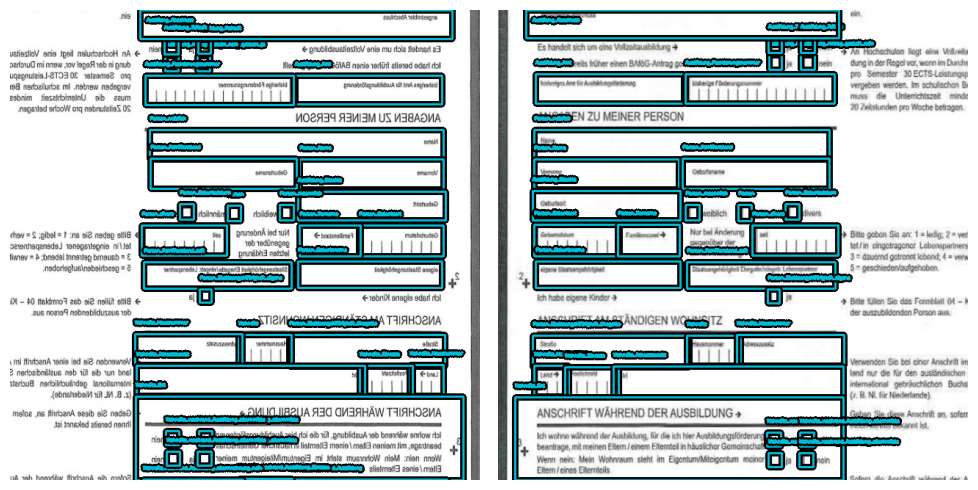

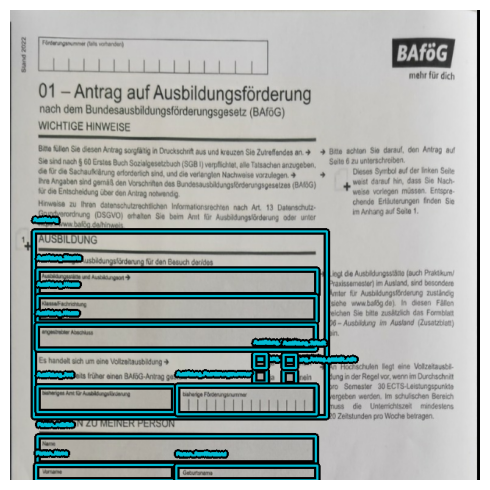

In [21]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
 
visualize_dataset(
    sub_train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2
)
 
visualize_dataset(
    sub_val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

In [22]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
 
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
 
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

main_train_ds = main_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_train_ds = main_train_ds.prefetch(tf.data.AUTOTUNE)
 
main_val_ds = main_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_val_ds = main_val_ds.prefetch(tf.data.AUTOTUNE)

sub_train_ds = sub_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_train_ds = sub_train_ds.prefetch(tf.data.AUTOTUNE)
 
sub_val_ds = sub_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_val_ds = sub_val_ds.prefetch(tf.data.AUTOTUNE)

define backbone

In [23]:
def define_backbone(backbone):
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_xs_backbone_coco",
         load_weights=True 
    )
    return backbone

define optimizer

In [24]:
def define_optimizer():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                        # don’t become exceedingly large and destabilize training.
    )
    return optimizer

define YOLO8Detector

In [25]:
def define_model(num_classes):
    model = keras_cv.models.YOLOV8Detector(
    num_classes=num_classes, #the number of object classes
    bounding_box_format="xyxy",
    backbone=define_backbone("yolo_v8_xs_backbone_coco"),
    fpn_depth=1,
)
    return model

compile model

In [26]:
def compile_model(model):
    model.compile(
    optimizer=define_optimizer(), 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

fit model

In [27]:
def fit_model(model, train_data, validation_data):
    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=EPOCH
        #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],
    )
    return history

define NonMaxSuppression

In [28]:
def define_NonMaxSuppression(model):
    model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.9,
        confidence_threshold=0.5
    
    )

define a base model, compile the base model and then loads the weights from a path

In [29]:
def load_weight_model(model_path):
    base_model = define_model(len(class_mapping))
    compile_model(base_model)
    loaded_model = base_model.load_weights(model_path)
    return  loaded_model
    

save weights of a model

In [30]:
def save_weights(model, name):
    save_model_path = gv_path_models + name
    model.save_weights(save_model_path)

define visualization methode

In [31]:
def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping= class_mapping ,#class_mapping,
    )

define and compile model for sub_bbox

In [32]:
yolo_coco_sub = define_model(len(sub_class_mapping))
compile_model(yolo_coco_sub)

define and compile model for main_bbox

In [33]:
yolo_coco_main = define_model(len(main_class_mapping))
compile_model(yolo_coco_main)

In [34]:
MAIN_MODEL_PATH = gv_bbox_path+'/main_bbox_detector_model.h5'

#yolo_coco_main.load_weights(MAIN_MODEL_PATH)

fit main_bbox_model

In [35]:
main_bbox_history = fit_model(yolo_coco_main, main_train_ds, main_val_ds )

Epoch 1/50


7/7 [==============================] - 32s 962ms/step - loss: 1893.0105 - box_loss: 3.1746 - class_loss: 1889.8359 - val_loss: 446.6299 - val_box_loss: 3.9105 - val_class_loss: 442.7193
Epoch 2/50
7/7 [==============================] - 3s 439ms/step - loss: 450.2763 - box_loss: 3.1731 - class_loss: 447.1031 - val_loss: 651.8537 - val_box_loss: 4.0364 - val_class_loss: 647.8173
Epoch 3/50
7/7 [==============================] - 3s 433ms/step - loss: 453.1433 - box_loss: 3.0144 - class_loss: 450.1289 - val_loss: 1490.1271 - val_box_loss: 3.9925 - val_class_loss: 1486.1345
Epoch 4/50
7/7 [==============================] - 3s 436ms/step - loss: 594.5222 - box_loss: 2.9926 - class_loss: 591.5296 - val_loss: 751.4130 - val_box_loss: 2.0889 - val_class_loss: 749.3241
Epoch 5/50
7/7 [==============================] - 3s 436ms/step - loss: 298.8463 - box_loss: 2.4934 - class_loss: 296.3528 - val_loss: 202.3315 - val_box_loss: 2.1771 - val_class_loss: 200.1544
Epoch 6/50
7/7 [=======

fit sub_bbox_model

In [36]:
#sub_bbox_history = fit_model(yolo_coco_sub, sub_train_ds, sub_val_ds )

visualization main bbox

1/1 [==============================] - 4s 4s/step


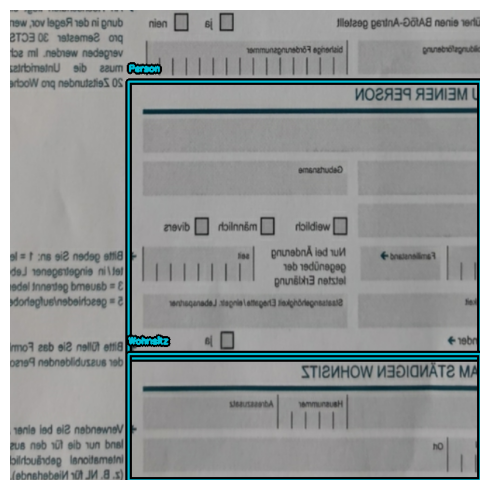

In [37]:
visualize_detections(yolo_coco_main, dataset=main_val_ds, bounding_box_format="xyxy", class_mapping= main_class_mapping)

visualization sub bbox

1/1 [==============================] - 2s 2s/step


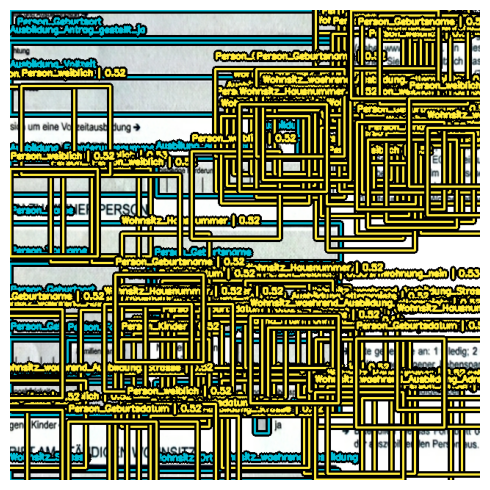

In [38]:
visualize_detections(yolo_coco_sub, dataset=sub_val_ds, bounding_box_format="xyxy", class_mapping= sub_class_mapping)

save weights

In [45]:
MAIN_MODEL_PATH = gv_bbox_path+'/main_bbox_detector_model.h5'
SUB_MODEL_PATH = gv_bbox_path+'/sub_bbox_detector_model.h5'

yolo_coco_main.save_weights(MAIN_MODEL_PATH)
yolo_coco_sub.save_weights(SUB_MODEL_PATH)

In [40]:
#yolo_coco_main.load_weights(MAIN_MODEL_PATH)

1/1 [==============================] - 0s 416ms/step


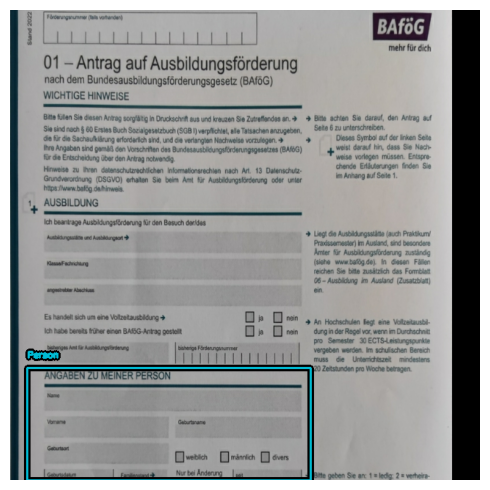

In [41]:
visualize_detections(yolo_coco_main, dataset=main_val_ds, bounding_box_format="xyxy", class_mapping= main_class_mapping)

load model for sub_bbox and visualize

In [42]:
yolo_coco_sub.load_weights(SUB_MODEL_PATH)

visualize a prediction with loaded_sub_model

1/1 [==============================] - 0s 75ms/step


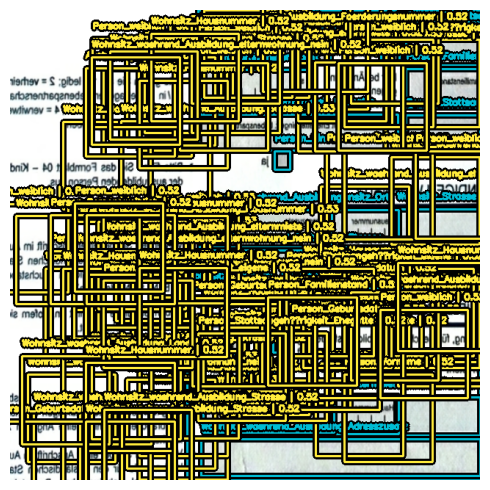

In [43]:
visualize_detections(yolo_coco_sub, dataset=sub_val_ds, bounding_box_format="xyxy", class_mapping= sub_class_mapping)

In [44]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs